# Testing differing deconv parameters for data

To find out which make the most sense

In [1]:
import sys,os,os.path
sys.path.append("/scratch/halmazan/NEXT/IC_alter-blob-centre/IC/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/scratch/halmazan/NEXT/testing/notebooks/")
os.environ['ICTDIR']='/scratch/halmazan/NEXT/IC_alter-blob-centre/IC/'

#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import invisible_cities.core.core_functions                   as     coref
import invisible_cities.io.dst_io                           as     dstio

from invisible_cities.cities.beersheba                 import cut_over_Q, drop_isolated, deconvolve_signal


from invisible_cities.database.load_db       import DataSiPM

from invisible_cities.evm.event_model        import Cluster, Hit
from invisible_cities.types.ic_types         import xy
from invisible_cities.reco.paolina_functions import voxelize_hits

from invisible_cities.evm.event_model        import HitEnergy
from invisible_cities.cities.beersheba          import DeconvolutionMode
from invisible_cities.cities.beersheba          import CutType


from invisible_cities.reco.deconv_functions import deconvolve
from invisible_cities.reco.deconv_functions import deconvolution_input
from invisible_cities.reco.deconv_functions import InterpolationMethod

import invisible_cities.io.mcinfo_io as mcio


import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [29]:
import glob

# Input file and some event IDs to look at.

typefile = 'sophronia' #'esmeralda'
RUN = 15589

fpath = f'/data/halmazan/NEXT/N100_LPR/15589/sophronia/prod/ldc1/'
file_pattern = f'{fpath}run_{RUN}_*_ldc1_trg2.v2.3.1.20250708.HEDesman.sophronia.h5'
files = glob.glob(file_pattern)

# Select the first file that matches the pattern
file = files[0] if files else None

pitch = 15.55

detector_db     = '/scratch/halmazan/NEXT/IC_alter-blob-centre/IC/invisible_cities/database/localdb.NEXT100DB.sqlite3'
run_number      = RUN

datatype = 'data'



# Parameters involved in beersheba city and the deconvolution.
nhits = 3
deconv_params = dict(
  q_cut            = 5, #5 for 6mm  - 5 for 6mm
  drop_dist        = [16, 16, 4],
  #psf_fname        = f'/Users/halmamol/NEXT/PSF_FLEX100_mask{dist}_lowQE.h5',     
  psf_fname        = f'/scratch/halmazan/NEXT/N100_LPR/lighttables/040925_full_25us.psf',     
  e_cut            = 0.2, #15 for 6mm  - 15 for 6mm
  n_iterations     = 25, #150 for 6mm  - 150 for 6mm
  iteration_tol    =  1e-10,
  sample_width     = [15.55, 15.55],
  bin_size         = [ 1,  1],
  diffusion        = (1., 1.),
  n_dim            = 2,
  deconv_mode      = DeconvolutionMode.joint,
  cut_type         = CutType.rel,
  energy_type      = HitEnergy.Ec,
  satellite_params = None)#,
  
 # inter_method    = InterpolationMethod.cubic)


#DeconvolutionMode
                
deconv_params_   = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}

# Couple of functions used in beersheba.

cut_sensors       = cut_over_Q   (deconv_params['q_cut'    ], ['E', 'Ec'])
drop_sensors      = drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'], nhits)

In [30]:
# load in the file
hdst = dstio.load_dsts(files[:50], 'RECO', 'Events')
dst = dstio.load_dsts(files[:50], 'DST', 'Events')

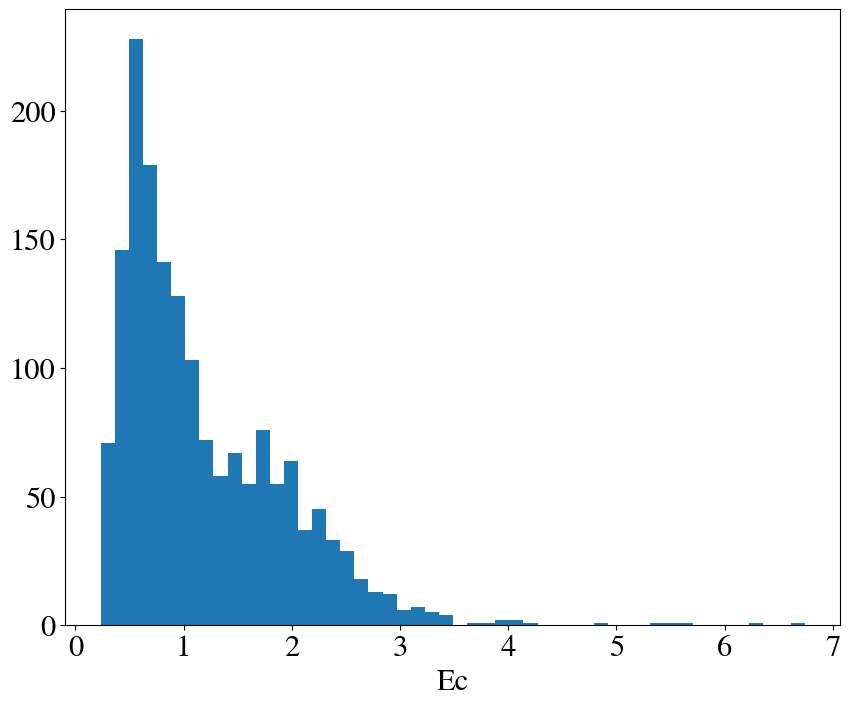

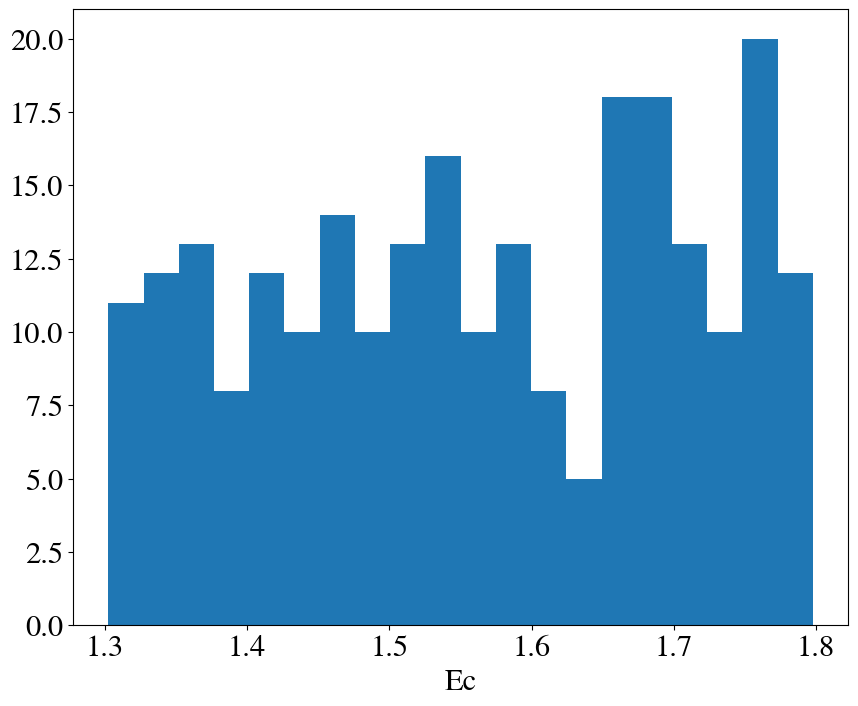

In [31]:

plt.hist(hdst.groupby('event').Ec.sum(), bins = 50)
plt.xlabel('Ec')
plt.show()

# ROI dataset
cutdst = hdst[hdst.groupby('event').Ec.transform('sum').between(1.3, 1.8)]
plt.hist(cutdst.groupby('event').Ec.sum(), bins = 20)
plt.xlabel('Ec')
plt.show()

In [32]:
evt  = cutdst.event.unique()[11]
hits = cutdst[cutdst.event == evt]

In [33]:
x_range = (hits.X.max()-hits.X.min())/2.
y_range = (hits.Y.max()-hits.Y.min())/2.
z_range = (hits.Z.max()-hits.Z.min())/2.
mid_x   = (hits.X.max()+hits.X.min())/2.
mid_y   = (hits.Y.max()+hits.Y.min())/2.
mid_z   = (hits.Z.max()+hits.Z.min())/2.

xbins = int(hits.X.max()-hits.X.min())
ybins = int(hits.Y.max()-hits.Y.min())
zbins = int((hits.Z.max()-hits.Z.min())/2.)

Text(0.5, 0.98, 'Sensors Signal')

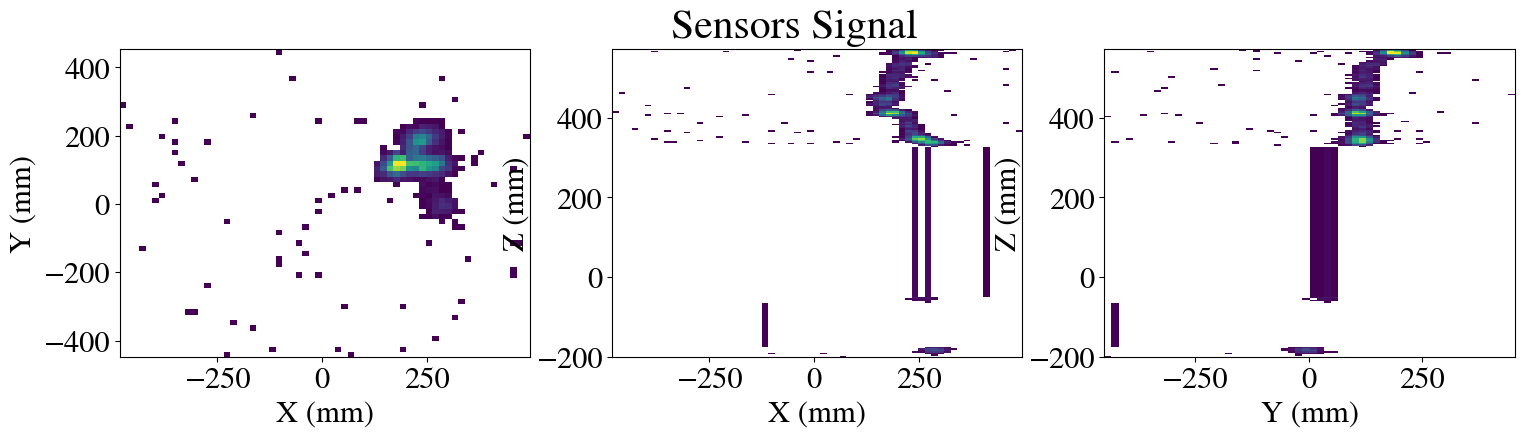

In [34]:
# then applying transformations to convert to 'SiPM outputs'
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('Sensors Signal', fontsize=30)

In [35]:
qmin = deconv_params['q_cut']
print(f'Cutting sensors below {qmin}')

Cutting sensors below 5


In [36]:
hits_cut = coref.timefunc(cut_sensors)(hits.copy())
hits_drop = drop_sensors(hits_cut.copy())

Time spent in cut_over_Q: 0.014416694641113281 s


/scratch/halmazan/NEXT/IC_alter-blob-centre/IC/invisible_cities/reco/hits_functions.py:145: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  cdst = df.groupby(['event', 'npeak']).apply(cut).reset_index(drop=True)
/scratch/halmazan/NEXT/IC_alter-blob-centre/IC/invisible_cities/reco/hits_functions.py:268: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  pass_df = df.loc[passing_hits, :].copy()
/scratch/halmazan/NEXT/IC_alter-blob-centre/IC/invisible_cities/reco/hits_functions.py:268: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a

Text(0.5, 0.98, 'Cut & Drop Sensors ($q_{cut}$)')

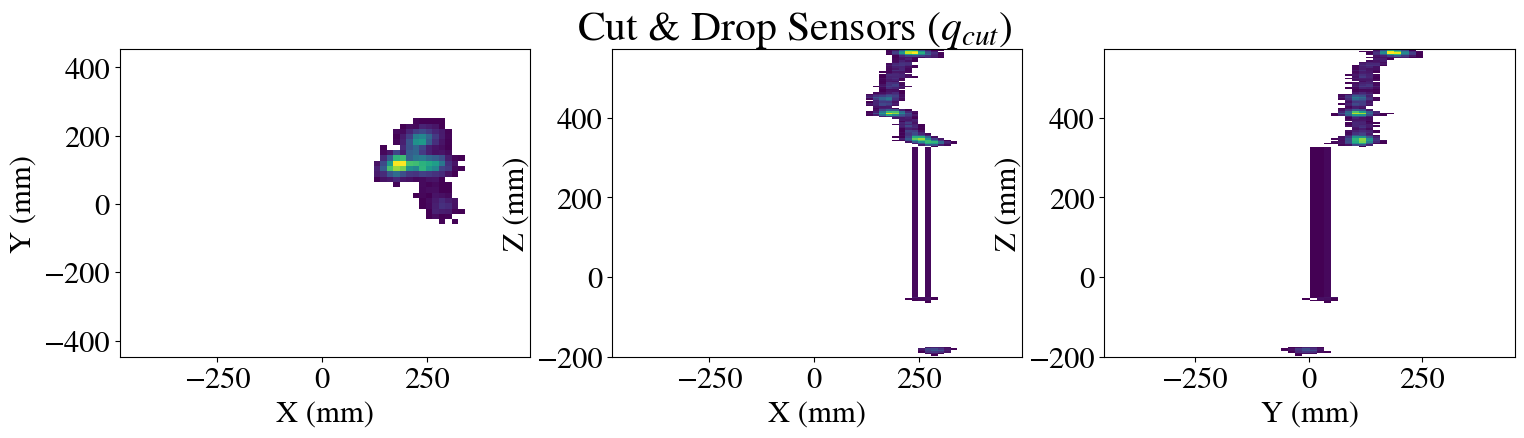

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');
fig.suptitle('Cut & Drop Sensors ($q_{cut}$)', fontsize=30)

In [38]:
deconvolver = deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())

Time spent in apply_deconvolution: 9.967159986495972 s


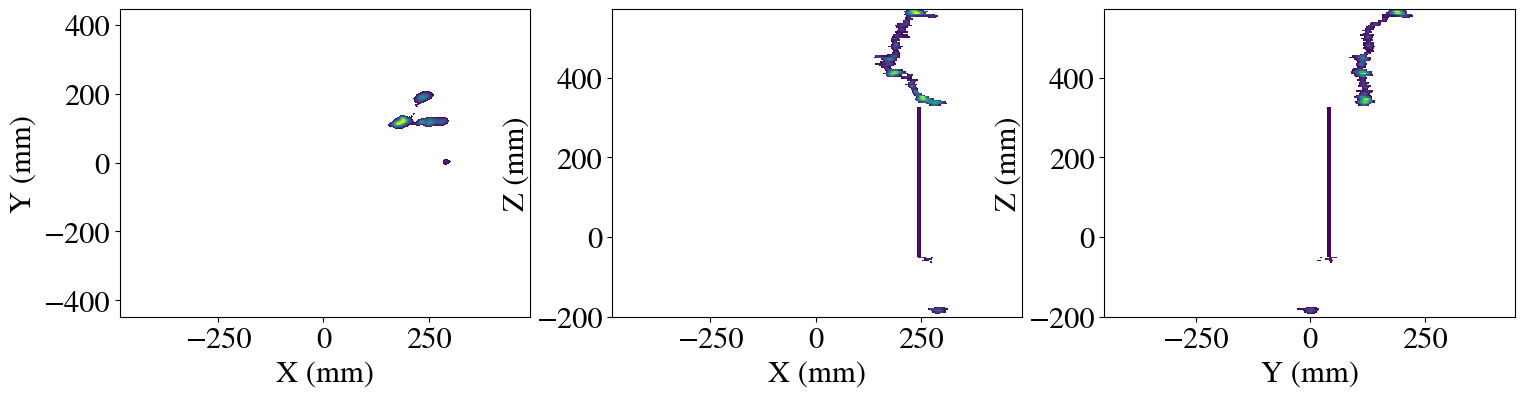

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max())
yy = np.arange(hits.Y.min(), hits.Y.max())
zz = hits.Z.unique()

axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

In [40]:
x = hits_deco.X
y = hits_deco.Y
z = hits_deco.Z
e = hits_deco.E*1000

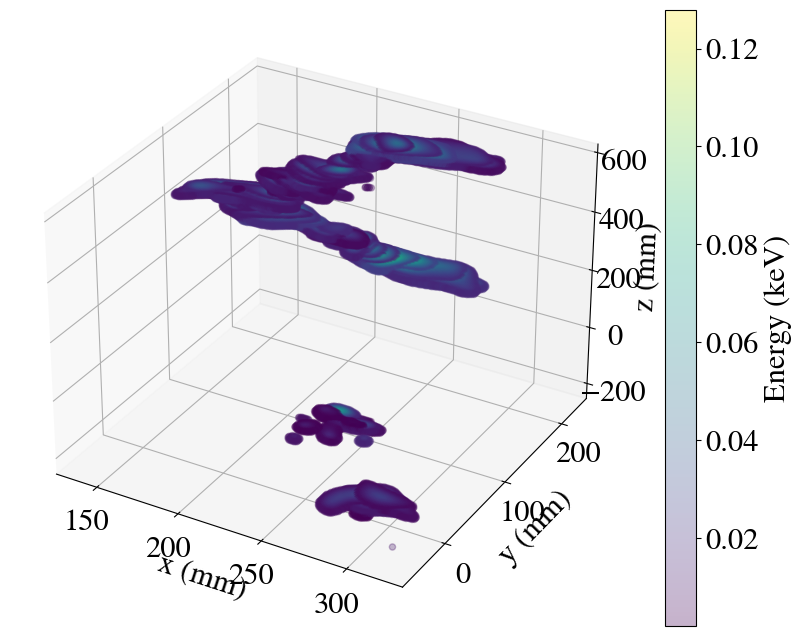

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(x, y, z, c=e, alpha=0.3, cmap='viridis')
cb = fig.colorbar(p, ax=ax)
cb.set_label('Energy (keV)')

ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')

plt.show()

/tmp/ipykernel_83099/589294615.py:72: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = fig.colorbar(sm)


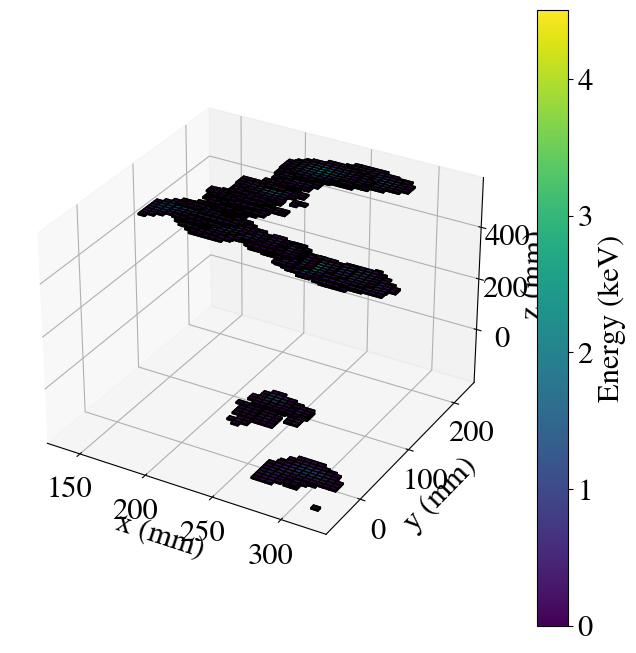

In [42]:
base_vsize = 5 #mm
the_hits = []

xs = hits_deco.X
ys = hits_deco.Y
zs = hits_deco.Z
es = hits_deco.E

for x, y, z, e in zip(xs, ys, zs, es):
    if np.isnan(e): continue
    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
    the_hits.append(h)

voxels = voxelize_hits(the_hits,
                       np.array([base_vsize, base_vsize, base_vsize]), False)

vsizex = voxels[0].size[0]
vsizey = voxels[0].size[1]
vsizez = voxels[0].size[2]

min_corner_x = min(v.X for v in voxels) - vsizex/2.
min_corner_y = min(v.Y for v in voxels) - vsizey/2.
min_corner_z = min(v.Z for v in voxels) - vsizez/2.

x = [np.round(v.X/vsizex) for v in voxels]
y = [np.round(v.Y/vsizey) for v in voxels]
z = [np.round(v.Z/vsizez) for v in voxels]
e = [v.E for v in voxels]

x_min = int(min(x))
y_min = int(min(y))
z_min = int(min(z))

x_max = int(max(x))
y_max = int(max(y))
z_max = int(max(z))

#print(f'X min = {x_min}, X max = {x_max}')
#print(f'Y min = {y_min}, Y max = {y_max}')
#print(f'Z min = {z_min}, Z max = {z_max}')

VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
#print(VOXELS.shape)

# sort through the event set the "turn on" the hit voxels
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=max(e))

colors = np.empty(VOXELS.shape, dtype=object)
for q in range(0,len(z)):
    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

# and plot everything
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
#a,b,c is spacing in mm needs an extra dim
a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
a = a*vsizex + min_corner_x
b = b*vsizey + min_corner_y
c = c*vsizez + min_corner_z

# a, b, c are the corners of the voxels
ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

ax.set_xlabel('x (mm)')#,fontsize=16)
ax.set_ylabel('y (mm)')#,fontsize=16)
ax.set_zlabel('z (mm)')#,fontsize=16)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm)
cb.set_label('Energy (keV)')

plt.show()